<a href="https://colab.research.google.com/github/RDifault/Harris-FLANN-BFMatcher/blob/main/Face_Detection_Using_HOG_and_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#FACE DETECTION USING HOG FEATURES AND LINEAR SVM

In [ ]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
from skimage.transform import resize
from skimage import data, color, feature
import skimage.data
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from skimage.transform import resize

Saya akan menggunakan 10 data pertama dari dataset Positive Faces pada link berikut : https://www.kaggle.com/gasgallo/faces-data

Saya akan menggunakan 20 data pertama dari dataset Negative Faces pada link berikut : https://www.kaggle.com/lasaljaywardena/furniture-images-dataset

#a.	Of your choice, build a dataset containing P positive images (face) and N negative images (non-face) where N>>P and save several face images for testing the detector later on.

Dikarenakan jumlah N>P, maka saya menggunakan 20 gambar non-faces dan 10 gambar faces dan di resize menjadi 128x128

In [ ]:
faces = []
non_faces = []

face_base_path = 'faces/'
non_face_base_path = 'non-faces/'

face_path = os.listdir(face_base_path)[:10]
non_face_path = os.listdir(non_face_base_path)[:20]

In [ ]:
for i in face_path:
    image_bgr = cv2.imread(face_base_path + i)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    image_resized = resize(image_rgb, (128, 128))
    faces.append(image_resized)

faces = np.asarray(faces)
faces.shape

(10, 128, 128)

In [ ]:
for i in non_face_path:
    image_bgr = cv2.imread(non_face_base_path + i)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    image_resized = resize(image_rgb, (128, 128))
    non_faces.append(image_resized)

non_faces = np.asarray(non_faces)
non_faces.shape

(20, 128, 128)

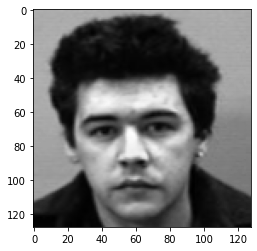

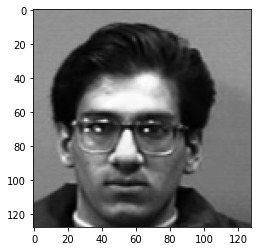

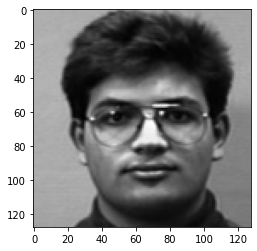

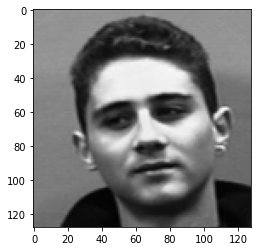

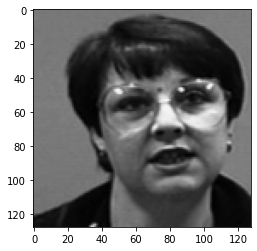

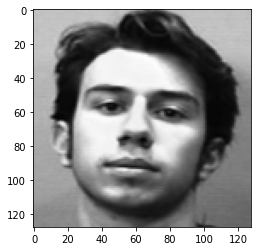

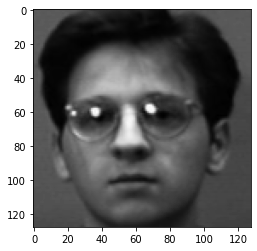

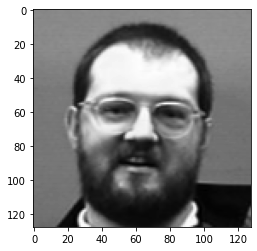

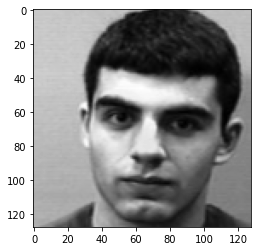

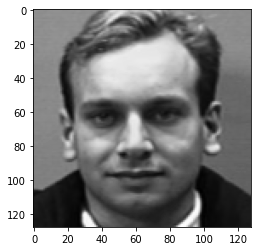

In [ ]:
for i in faces :
  plt.imshow(i, cmap='gray')
  plt.show()

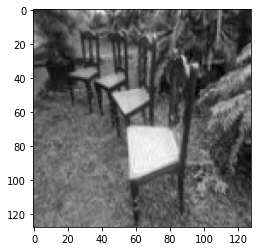

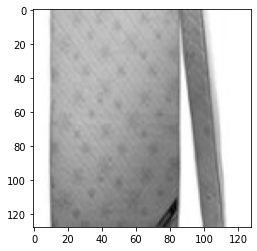

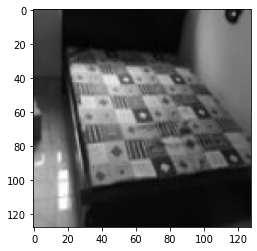

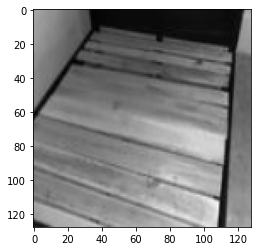

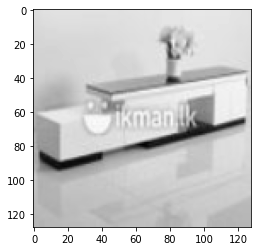

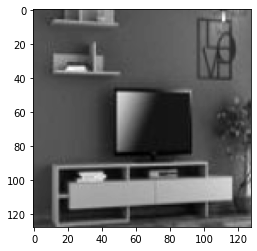

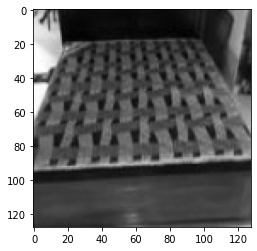

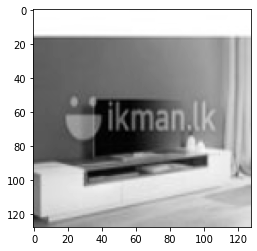

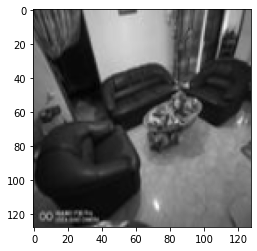

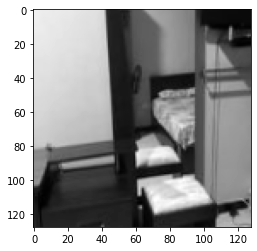

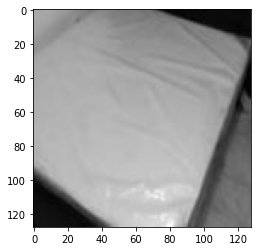

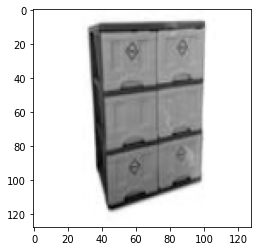

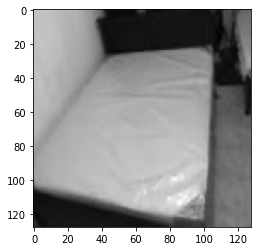

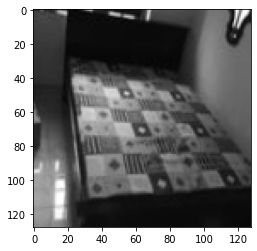

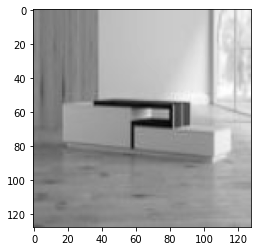

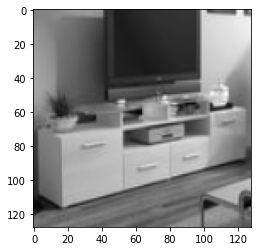

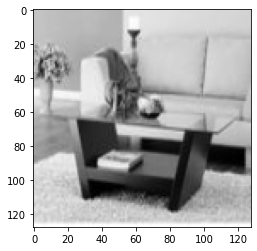

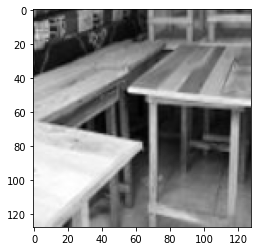

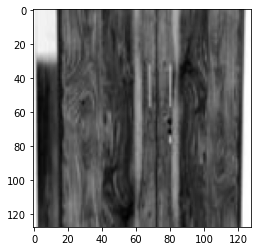

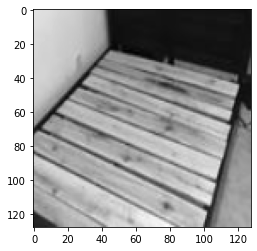

In [ ]:
for j in non_faces :
  plt.imshow(j, cmap='gray')
  plt.show()

#b.	Extract the HOG features of both positive and negative images and train using linear SVM. Once the training is completed, save the model.

##Extract HOG Features

In [ ]:
from itertools import chain
X_train = np.array([feature.hog(im)
                    for im in chain(faces,
                                    non_faces)])
y_train = np.zeros(X_train.shape[0])
y_train[:faces.shape[0]] = 1

In [ ]:
X_train.shape

(30, 15876)

##Training SVM

In [ ]:
cross_val_score(GaussianNB(), X_train, y_train)

array([0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667])

In [ ]:
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

0.9666666666666668

In [ ]:
grid.best_params_

{'C': 1.0}

In [ ]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC()

#c.	Test the model using sliding window, you may get overlapping windows surrounding the face image.

Mengambil gambar baru untuk di test. Gambar yang saya gunakan dapat di download pada link berikut : https://drive.google.com/file/d/1LjtB10iZlUb0MJcgXpOO0kAKiy5r_4j6/view?usp=sharing

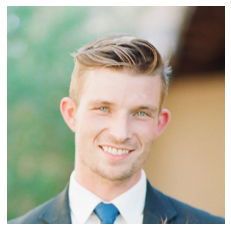

In [ ]:
test_img = cv2.imread('test_img2.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img = resize(test_img, (256, 256))

plt.imshow(test_img)
plt.axis('off');

Membuat fungsi sliding window

In [ ]:
def sliding_window(img, patch_size=faces[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = patch.resize(patch, patch_size)
            yield (i, j), patch

indices, patches = zip(*sliding_window(test_img))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(4096, 15876)

In [ ]:
labels = model.predict(patches_hog)
labels.sum()

34.0

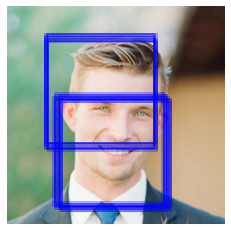

In [ ]:
fig, ax = plt.subplots()
ax.imshow(test_img, cmap='gray')
ax.axis('off')

Ni, Nj = faces[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='blue',
                               alpha=0.3, lw=2, facecolor='none'))